# Sparse Ternary Networks

Sparse Ternary Networks consist of multi layers of units, each performing an encoding stage to come up with a latent code and a decoding stage to reconstruct the input from the latent code.

The encoding at each unit is done using Sparse Ternary Codes (STC's), which was originally designed to address the probplem of fast search. These codes are sparse, i.e., they contain a large portion of zeros and also ternary, i.e., their alphabet is limited to three elements $\mathcal{X} = \{+1,0,-1\}$. This makes their storage and implementation very efficient using fixed-point operations.

See [these two](http://sip.unige.ch/articles/2017/Sohrab_ISIT17.pdf) [papers](http://sip.unige.ch/articles/2016/WIFS_2016_final.pdf) for more information regarding STC's for fast search and the motivations behind ternary encoding.

## Rate-distortion of synthetic sources

We demonstrate the compression performance of the Sparse Ternary Networks by studying their rate-distortion performance in comparison with the Shannon Lower Bound, i.e., the best possible trade-off theoretically achievable when the dimension $n \rightarrow \infty$.

We first consider Gaussian sources with known covariance matrices. As a special case, we consider the AR(1) process whose covariance matrix is very intuitive to construct.

The idea behind choosing a synthetic source is to be able to compare the performance of the network with the theoretically ideal performance since, unlike real data, we (almost) know how to calculate it.


In [1]:
# First importing the required packages:
%matplotlib inline
import sparse_ternary_networks.Tools as T
import numpy as np
import sparse_ternary_networks.Basics as STNet
from scipy.linalg import eigh
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

In [2]:
# Initializing the parameters:
n = 512      # dimension
m = 512       # dimension of the codes
N = 10000     # number of samples, say for both train and test sets.
k = 10         # number of non-zero elements of the STC at each stage.
L = 25        # number of layer units of the network.
Rho = 0.9     # the coefficient of the AR(1) source.

In [3]:
# The covariance matrix of the AR(1) process with its toeplitz structure:
cov_mat = toeplitz(Rho**np.arange(n))
# Generating the train and test sets:
F0_train = np.linalg.cholesky(cov_mat) @ np.random.randn(n,N)
F0_test = np.linalg.cholesky(cov_mat) @ np.random.randn(n,N)
# Normalization (scalar):
# F0_train -= np.mean(F0_train)
# F0_train /= np.std(F0_train)
# #
# F0_test -= np.mean(F0_test)
# F0_test /= np.std(F0_test)

### Theoretically optimal R-D performance of AR(1) sources:
For i.i.d. sequences, as a special case of AR(1) (with $\rho = 0$), the Shannon Lower Bound (SLB) for a source with variance $\sigma^2$ has a closed-form expression:

$D(R) = \sigma^2 2^{-2R}.$

For independent but not-identically distributed sequences, however, there is no closed-form expression and the rate-distortion follows the so-called "reverse-water-filling" paradigm (see e.g. [here](https://pdfs.semanticscholar.org/5b70/96d8e6d97bda53ed0ab9364c4840f274266e.pdf)).

For non-independent sources, the reverse-water-filling procedure should be applied to the eigen-values of the covariance matrix as is done next.


Bellow we perform the water-filling for the AR(1) process:

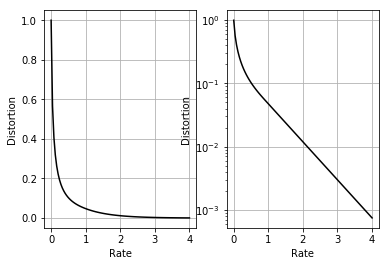

In [4]:
# SLB calculation using reverse-water-filling:
EigValues, _ = eigh(cov_mat)
Rate_SLB= np.linspace(0,4,100)
Distortion_SLB = []
for Rate in Rate_SLB:
    Distortion_SLB.append(np.sum(T.rev_WaterFiller(EigValues,Rate)[3])/n)
#
plt.subplot(1,2,1)
plt.plot(Rate_SLB,Distortion_SLB,color='BLACK') 
plt.grid()
plt.xlabel('Rate')
plt.ylabel('Distortion')
#
plt.subplot(1,2,2)
plt.semilogy(Rate_SLB,Distortion_SLB,color='BLACK') 
plt.grid()
plt.xlabel('Rate')
plt.ylabel('Distortion')

### Training the sparse ternary networks for the AR(1) source:
We now train the sparse ternary networks on the above source and then use the trained parameters for the compression of the test set:

In [5]:
# Training the network:50
obj_train = STNet.BaseLearner(k,L,m=m)
_,_,_ = obj_train.run(F0_train)

 ################## Starting to learn network parameters:  ##################
layer-units:
** 1 **** 2 **** 3 **** 4 **** 5 **** 6 **** 7 **** 8 **** 9 **** 10 **** 11 **** 12 **** 13 **** 14 **** 15 **
** 16 **** 17 **** 18 **** 19 **** 20 **** 21 **** 22 **** 23 **** 24 **** 25 **
Finished learning network parameters:


In [6]:
# Testing the network:
obj_test = STNet.fwdPass(obj_train.params,k,ternaryProbMap=obj_train.prob_z)
_,_,_ = obj_test.run(F0_test)

 Running the network:
 ##################  Running the network:  ##################
layer-units:
** 1 **** 2 **** 3 **** 4 **** 5 **** 6 **** 7 **** 8 **** 9 **** 10 **** 11 **** 12 **** 13 **** 14 **** 15 **
** 16 **** 17 **** 18 **** 19 **** 20 **** 21 **** 22 **** 23 **** 24 **** 25 **
Finished running the network.


Let's visualize the performance on the training set and the test set and compare them with the ideal theoretical lower bound. Note that this bound is achieved only asymptotically when $n \rightarrow \infty$.

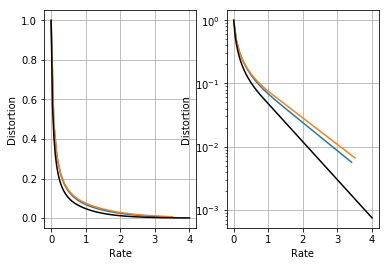

In [7]:
plt.subplot(1,2,1)
plt.plot(obj_train.rate,obj_train.distortion)
plt.plot(obj_test.rate,obj_test.distortion)
plt.grid()
plt.plot(Rate_SLB,Distortion_SLB,color='BLACK')
plt.xlabel('Rate')
plt.ylabel('Distortion')
# 
plt.subplot(1,2,2)
plt.semilogy(obj_train.rate,obj_train.distortion)
plt.semilogy(obj_test.rate,obj_test.distortion)
plt.grid()
plt.semilogy(Rate_SLB,Distortion_SLB,color='BLACK')
plt.xlabel('Rate')
plt.ylabel('Distortion')

We can see a decent R-D performance on the AR(1) source. We should next see how we are doing on non-synthetic real data.

In [8]:
# Learner = 'highCorr_SuccessivePCA'
# Database = 'Synthetic'
# PGF_path = '/home/sssohrab/Dropbox/Publications/ECCV_2018/Pics/PGF/Running/'
# suffix = '_k' + str(int(np.mean(k))) + '_L' + str(L) + '_m' + str(int(np.mean(m))) + '_'+ Learner
# ######
# fname = Database + '_D_R'  + suffix
# np.savetxt(PGF_path + fname + '.dat', np.transpose([obj_test.rate, obj_test.distortion]), fmt='%8f')
# #####
# fname = Database + '_Dhat_R'  + suffix
# np.savetxt(PGF_path + fname + '.dat', np.transpose([obj_train.rate, obj_train.distortion]), fmt='%8f')